# Deep Unfolding applied to gradient descent
using: \
Julia 1.8.2 \
Flux.jl 0.13.6 \
Zygote.jl 0.6.49 \
Symbolics 5.10.0 \
\
In this Jupyter notebook, I explore applying Deep Unfolding (DU) to gradient descent algorithms. The notebook is based on Tadashi Wadayama's work found at https://github.com/wadayama/DU-Book/blob/main/Chapter_3/. 

Deep Unfolding treats iterative algorithms as if each iteration were a layer in a deep neural network. In this notebook, I consider applying DU to gradient descent, which iteratively modifies an input vector $x_k$ to minimize an objective function $f(x)$ using the recursive formula:

$$
x_{k+1} = x_k -\eta\cdot\nabla f(x_k),
$$

where $\nabla f(x)$ is the gradient of $f(x)$, and $\eta$ is the step size parameter. Here, $\eta$ is a parameter to be learned. 

I calculate $\nabla f(x)$ symbolically and use it in the recursive equation, converting it to a numerically evaluated function. Meanwhile, I calculate the gradient of the DU parameters (here just the scalar $\eta$) via automatic differentiation and optimize it using the Adam algorithm.

## A simple constant-parameter-learning example

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Symbolics

Define an objective function to minimize. We use Symbolics package to compute the gradient of the function.

In [2]:
@variables x[1:2]

#f(x)=(1-x[1])^2+100*(x[2]-x[1]^2)^2 # Rosenbrock function
f(x) = x[1]^2+x[2]^2 # Quadratic function

g(x)=Symbolics.gradient(f(x),Symbolics.get_variables(f(x))) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient
callable_gradient([1,1]) # sanity check

2-element Vector{Int64}:
 2
 2

Define a function that performs gradient descent. We will learn the step size $\eta$ or eta[1] (a scalar) using Deep Unfolding.

In [3]:
function GD_ki(max_itr, x0, eta)
    x = x0
    for i in 1:max_itr
        #df = gradient(() -> f(x), Flux.params(x)) 
        # The above line cannot be done because Flux.gradient cannot take gradient of itself.
        # We can hard-code df = 2*x or we can symbolically get the gradient and convert into a function 
        # returning numerical vector.
        
        x = x - eta[1].*callable_gradient(x)
    end
    return f(x)
end

GD_ki (generic function with 1 method)

Define the train function that does the "deep unfolding". Here we perform automatic differentiation of the gradient descent algorithm using Flux.gradient. 

In [4]:
function train_ki(opt, eta, max_itr, train_itr)
    ps = Flux.params(eta) 
    l = [] # will keep record of eta values in this list
    for i in 1:train_itr # perform gradient descent starting from train_iter random starting points
        push!(l,eta[1]) # like append in python
        gs = Flux.gradient(ps) do
            GD_ki(max_itr, randn(2), eta) # perform gradient descent for max_itr iterations 
        end
        Flux.Optimise.update!(opt, ps, gs)   
    end  
    return l
end

train_ki (generic function with 1 method)

We plot the history of $\eta$ with respect to training iteration. The optimization algorithm employed is ADAM. It converges to the optimal value of $\eta = 0.5$ for the quadratic function.

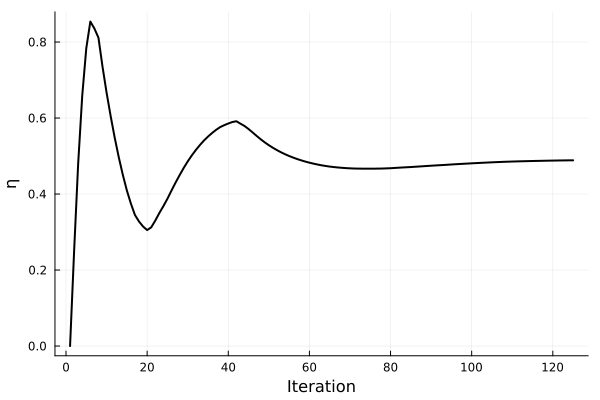

In [5]:
opt = Flux.ADAM(0.25) 
eta = [0.0]
max_itr = 2
train_itr = 125
l = train_ki(opt, eta, max_itr, train_itr)
plot(1:train_itr,l, xlabel="Iteration", ylabel="η",legend=false, lw=2,color=:black)

## A Second Quadratic Function Descent Example

In [42]:
n = 100
num_itr = 30
train_itr = 25
K = 50
adam_lr = 1e-3
max_inner = 20

20

In [43]:
A = diagm(1:n)
#println(A)
λmin = 1
λmax = n
ηopt = 1/(λmin + λmax)

0.009900990099009901

In [44]:
@variables x[1:n]
x=Symbolics.scalarize(x)
f(x)= x'*A*x

g(x)=Symbolics.gradient(f(x),[x[i] for i in 1:n]) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient



#45 (generic function with 1 method)

As a benchmark we compute fixed-step-size gradient descent.

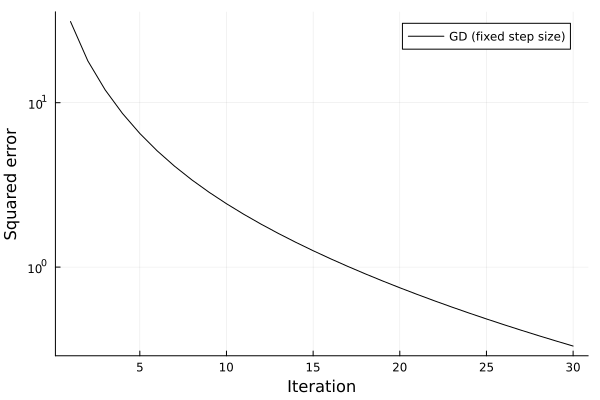

In [45]:
function GD_ki(max_itr, x0)
    x = x0
    for i in 1:max_itr
        #x = x - ηopt*2*A*x
        x = x - ηopt*callable_gradient(x)
    end
    return x
end

function comp_se(max_itr,x0)
    x̂ = GD_ki(max_itr, x0)
    return norm(x̂)^2
end

xinit = randn(n)
GD_mse = [comp_se(i,xinit) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Squared error")


In [46]:
function DU_GD_ki(max_itr, x0, η, T)
    x = x0
     
    for i in 0:max_itr-1
        k = (i % T)+1
        #x = x - η[k]*A*x
        if isa(x, Matrix)
            array_x = [callable_gradient(x[:,j]) for j in 1:K]
            x = x - η[k]*hcat(array_x...)
        else isa(x, Vector)
            x = x - η[k]*callable_gradient(x)
        end
    end
    return x
end

DU_GD_ki (generic function with 1 method)

In [47]:
function loss(x̂)
    return norm(x̂)^2/K
end 

loss (generic function with 1 method)

In [48]:
function train(opt, η, T, train_itr)
    ps = Flux.params(η) 
    for itr in 1:train_itr
        for i in 1:max_inner
            x0 = randn(n,K)
            gs = Flux.gradient(ps) do
                x_est = DU_GD_ki(itr, x0, η, T)
                loss(x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        x0 = randn(n,K)
        x_est = DU_GD_ki(itr, x0, η, T)
        println(itr, " ", loss(x_est))
    end
end

train (generic function with 1 method)

In [49]:
function comp_se_DUGD(max_itr, x0, η, T)
    x_est = DU_GD_ki(max_itr, x0, η, T)
    return loss(x_est)
end

comp_se_DUGD (generic function with 1 method)

1 27.098127544560498
2 10.743103938566582
3 6.380429311218176
4 4.2665224978578955
5 3.507168507482317
6 2.45480483859657
7 1.9715955271593406
8 1.551485392350275
9 1.2288003359287136
10 1.063473102414419
11 0.90203601788689
12 0.951206625376302
13 0.7352758029031611
14 0.5094594028283521
15 0.5620863349720446
16 0.4543609149515293
17 0.3432376790242948
18 0.3316589745211572
19 0.2834131061315366
20 0.23366177554645387
21 0.2624673522193991
22 0.23156229102189316
23 0.15460203807847778
24 0.187277646496178
25 0.1696936987814327


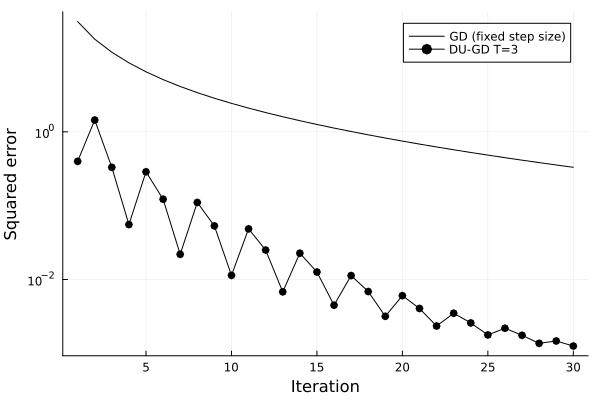

In [50]:
T = 3
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T, train_itr)
DUGD_mse =[comp_se_DUGD(i, xinit, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)